In [6]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix

import category_encoders as ce

In [7]:
!ls data/

ames_test.csv                    diabetes.csv
ames_train.csv                   kc_house_data.csv
auto-mpg.csv                     salaries_final.csv
cat_in_the_dat2_train.csv        titanic.csv
data_banknote_authentication.csv


In [8]:
def evaluate(estimator, X_train, X_test, y_train, y_test):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # for binary case in particular, can look at predicted probabilities
    # train_preds_proba = estimator.predict_proba(X_train)[:, 1]
    # test_preds_proba = estimator.predict_proba(X_test)[:, 1]
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds)}")
    print(f"ROC-AUC: {roc_auc_score(y_train, estimator.decision_function(X_train))}")
    print('-----------')
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds)}")
    print(f"ROC-AUC: {roc_auc_score(y_test, estimator.decision_function(X_test))}")
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test)
    plt.show()

In [9]:
df = pd.read_csv("data/cat_in_the_dat2_train.csv")

In [10]:
df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [11]:
# Define our X and y
X = df.drop(columns=['target'])
y = df['target']

# and train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [12]:
# Set up how to treat our columns

# Want to grab numeric columns
# Then grab columns with fewer than 10 unique values
# Then grab columns with more than 10, since we won't OHE those

num_cols = []
ohe_cols = []
freq_cols = []
    
for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif len(X[c].unique()) <= 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [13]:
# Now, set up the preprocessing steps for each type of col
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

ohe_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

freq_transformer = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('freq_enc', ce.CountEncoder(normalize=True,
                                 handle_unknown=0,
                                 min_group_size=0.001,
                                 min_group_name='Other'))])

In [14]:
# Put together our preprocessor using a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat_ohe', ohe_transformer, ohe_cols), 
        ('cat_freq', freq_transformer, freq_cols)])

In [15]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(class_weight='balanced'))])

clf_logreg.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['id', 'bin_0', 'bin_1',
                                                   'bin_2', 'ord_0', 'day',
                                                   'month']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),


Train Scores
------------
Accuracy: 0.6314
F1 Score: 0.39090935797065257
ROC-AUC: 0.6820917711594409
-----------
Test Scores
-----------
Accuracy: 0.63054
F1 Score: 0.3908594290990228
ROC-AUC: 0.6824319344179465


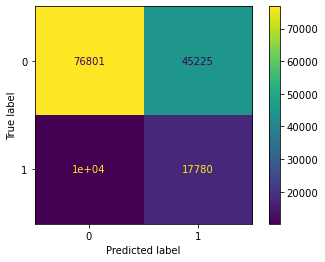

In [16]:
evaluate(clf_logreg, X_train, X_test, y_train, y_test)

In [17]:
clf_logreg.fit(X_train, y_train)

results = clf_logreg.predict_proba(X_test)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [18]:
results

array([[0.56782612, 0.43217388],
       [0.3305045 , 0.6694955 ],
       [0.67887755, 0.32112245],
       ...,
       [0.53511925, 0.46488075],
       [0.60562736, 0.39437264],
       [0.44121235, 0.55878765]])

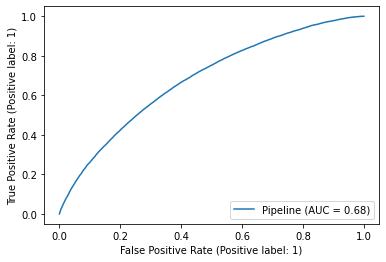

In [19]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(clf_logreg, X_test, y_test)

In [20]:
roc_auc_score(y_test, clf_logreg.decision_function(X_test))


0.6824319344179465